In [84]:
import pandas as pd
import seaborn as sns

# TODO: 15 pixels to mm is just a really rough initial estimate!
def normalize_df(df, window_size, pixel_to_mm=15):
    x0, y0 = df.iloc[0][['x', 'y']] 
    df['X displacement (mm)'] = - (df['x'] - x0) / pixel_to_mm
    df['Y displacement (mm)'] = - (df['y'] - y0) / pixel_to_mm
    
    df['X displacement smoothed (mm)'] = df['X displacement (mm)'].rolling(window=window_size, center=True).mean()
    df['Y displacement smoothed (mm)'] = df['Y displacement (mm)'].rolling(window=window_size, center=True).mean()
    
    df['X displacement smoothed (mm)'] = df['X displacement smoothed (mm)'].fillna(df['X displacement (mm)'])
    df['Y displacement smoothed (mm)'] = df['Y displacement smoothed (mm)'].fillna(df['Y displacement (mm)'])
    
    return df

In [86]:
Y_MIN = 0
Y_MAX = 25
X_MIN = -15
X_MAX = 20
TIME_MAX = 45

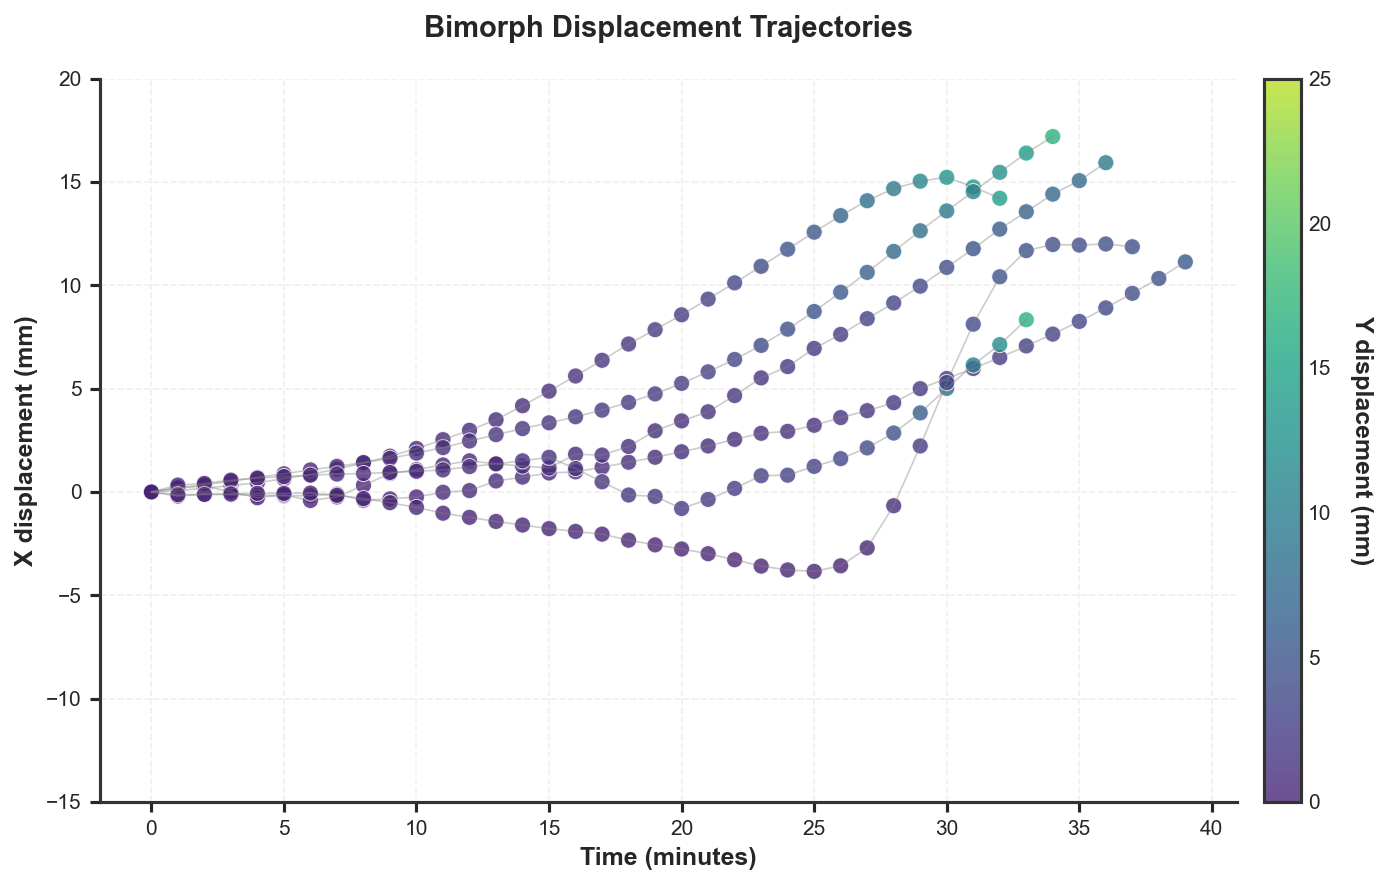

In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.cm as cm

# List of file paths for all datasets
file_paths = {
    "experimental_0": ("tracked_trajectories/bimorph_idx0_100x_tracked.csv", (0, 33), 5),
    "experimental_1": ("tracked_trajectories/bimorph_idx1_100x_tracked.csv", (0, None), 5),
    "experimental_2": ("tracked_trajectories/bimorph_idx2_100x_tracked.csv", (0, None), 5),
    "experimental_3": ("tracked_trajectories/bimorph_idx3_100x_tracked.csv", (0, None), 5),
    "experimental_4": ("tracked_trajectories/bimorph_idx4_100x_tracked.csv", (0, None), 5),
    "experimental_5": ("tracked_trajectories/bimorph_idx5_100x_tracked.csv", (0, None), 5),
}

# Set a professional style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#333333'

# Load and normalize each DataFrame, adding an experiment_id column
dfs = []
for name, (file, frames, window_size) in file_paths.items():
    df = normalize_df(pd.read_csv(file), window_size=window_size)  # Apply your normalize function
    df["experiment_id"] = name  # Label each dataset
    if frames[1] is not None:
        df = df.iloc[frames[0]:frames[1]]
    else:
        df = df.iloc[frames[0]:]
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Create a custom colormap for Y displacement
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", 
                                               plt.cm.viridis(np.linspace(0.1, 0.9, 256)))

# Create figure with higher resolution and better proportions
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Find the min and max Y values for color normalization
# vmin = #combined_df['Y displacement smoothed (mm)'].min()
# vmax = combined_df['Y displacement smoothed (mm)'].max()
norm = plt.Normalize(Y_MIN, Y_MAX)

# Create a scatter plot for each experiment
for name in combined_df['experiment_id'].unique():
    subset = combined_df[combined_df['experiment_id'] == name]
    
    # Create scatter plot with Y displacement as color
    scatter = ax.scatter(
        subset['minutes'], 
        subset['X displacement smoothed (mm)'],
        c=subset['Y displacement smoothed (mm)'],
        cmap=custom_cmap,
        norm=norm,
        s=60,  # Marker size
        alpha=0.8,  # Slight transparency
        edgecolors='white',  # White outline
        linewidth=0.5,  # Outline width
        label=name
    )

# Add a thin connecting line between points for each experiment (optional)
for name in combined_df['experiment_id'].unique():
    subset = combined_df[combined_df['experiment_id'] == name]
    ax.plot(
        subset['minutes'], 
        subset['X displacement smoothed (mm)'],
        '-',
        linewidth=0.8,
        alpha=0.4,
        color='gray'
    )

# Create a colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Y displacement (mm)', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Customize plot aesthetics
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('X displacement (mm)', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend with custom markers
handles, labels = ax.get_legend_handles_labels()
legend_elements = []
for i, label in enumerate(labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor=plt.cm.tab10(i), 
                          markersize=10))
# ax.legend(handles=legend_elements, title='Experiments', 
#           loc='upper right', frameon=True, fontsize=10)

# Set a better title
plt.title('Bimorph Displacement Trajectories', fontsize=14, fontweight='bold', pad=20)

# Adjust plot limits with some padding
minutes_min, minutes_max = combined_df['minutes'].min(), combined_df['minutes'].max()
ax.set_xlim(minutes_min - 0.05 * (minutes_max - minutes_min), minutes_max + 0.05 * (minutes_max - minutes_min))
ax.set_ylim(X_MIN, X_MAX)

# Add grid but keep it subtle
ax.grid(True, linestyle='--', alpha=0.3)

# Tight layout and save
plt.tight_layout()
plt.savefig('bimorph_displacement_publication.pdf', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

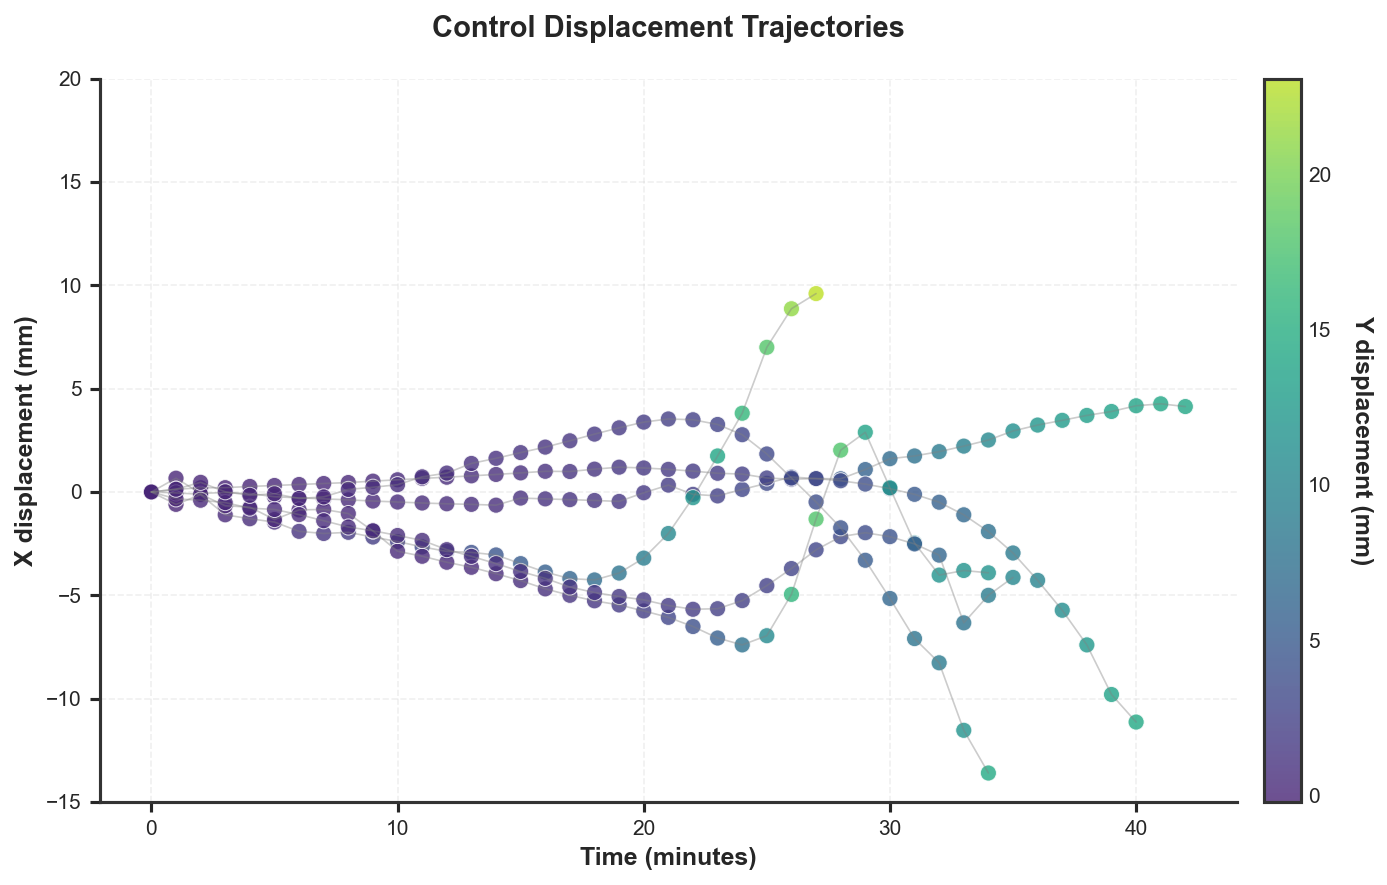

In [91]:

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.cm as cm

# List of file paths for all datasets
file_paths = {
    # "experimental_0": ("tracked_trajectories/bimorph_idx0_100x_tracked.csv", (0, 33)),
    # "experimental_1": ("tracked_trajectories/bimorph_idx1_100x_tracked.csv", (0, None)),
    # "experimental_2": ("tracked_trajectories/bimorph_idx2_100x_tracked.csv", (0, None)),
    # "experimental_3": ("tracked_trajectories/bimorph_idx3_100x_tracked.csv", (0, None)),
    # "experimental_4": ("tracked_trajectories/bimorph_idx4_100x_tracked.csv", (0, None)),
    # "experimental_5": ("tracked_trajectories/bimorph_idx5_100x_tracked.csv", (0, None)),
    'control_0': ('tracked_trajectories/control_idx0_100x_tracked.csv', (0, 43), 7),
    'control_1': ('tracked_trajectories/control_idx1_100x_tracked.csv', (0, None), 7),
    'control_2': ('tracked_trajectories/control_idx2_100x_tracked.csv',(0, None), 7),
    'control_3': ('tracked_trajectories/control_idx3_100x_tracked.csv', (0, 35), 3), # window=3
    'control_4': ('tracked_trajectories/control_idx4_100x_tracked.csv', (0, None), 7),  # isues with this one!
    'control_5': ('tracked_trajectories/control_idx5_100x_tracked.csv',(0, 35), 7),
}
# Set a professional style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#333333'

# Load and normalize each DataFrame, adding an experiment_id column
dfs = []
for name, (file, frames, window_size) in file_paths.items():
    df = normalize_df(pd.read_csv(file), window_size)  # Apply your normalize function
    df["experiment_id"] = name  # Label each dataset
    if frames[1] is not None:
        df = df.iloc[frames[0]:frames[1]]
    else:
        df = df.iloc[frames[0]:]
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Create a custom colormap for Y displacement
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", 
                                               plt.cm.viridis(np.linspace(0.1, 0.9, 256)))

# Create figure with higher resolution and better proportions
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Find the min and max Y values for color normalization
vmin = combined_df['Y displacement smoothed (mm)'].min()
vmax = combined_df['Y displacement smoothed (mm)'].max()
norm = plt.Normalize(vmin, vmax)

# Create a scatter plot for each experiment
for name in combined_df['experiment_id'].unique():
    subset = combined_df[combined_df['experiment_id'] == name]
    
    # Create scatter plot with Y displacement as color
    scatter = ax.scatter(
        subset['minutes'], 
        subset['X displacement smoothed (mm)'],
        c=subset['Y displacement smoothed (mm)'],
        cmap=custom_cmap,
        norm=norm,
        s=60,  # Marker size
        alpha=0.8,  # Slight transparency
        edgecolors='white',  # White outline
        linewidth=0.5,  # Outline width
        label=name
    )

# Add a thin connecting line between points for each experiment (optional)
for name in combined_df['experiment_id'].unique():
    subset = combined_df[combined_df['experiment_id'] == name]
    ax.plot(
        subset['minutes'], 
        subset['X displacement smoothed (mm)'],
        '-',
        linewidth=0.8,
        alpha=0.4,
        color='gray'
    )

# Create a colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Y displacement (mm)', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Customize plot aesthetics
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('X displacement (mm)', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend with custom markers
handles, labels = ax.get_legend_handles_labels()
legend_elements = []
for i, label in enumerate(labels):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor=plt.cm.tab10(i), 
                          markersize=10))
# ax.legend(handles=legend_elements, title='Experiments', 
#           loc='upper right', frameon=True, fontsize=10)

# Set a better title
plt.title('Control Displacement Trajectories', fontsize=14, fontweight='bold', pad=20)

# Adjust plot limits with some padding
minutes_min, minutes_max = combined_df['minutes'].min(), combined_df['minutes'].max()
ax.set_xlim(minutes_min - 0.05 * (minutes_max - minutes_min), minutes_max + 0.05 * (minutes_max - minutes_min))
ax.set_ylim(X_MIN, X_MAX)

# Add grid but keep it subtle
ax.grid(True, linestyle='--', alpha=0.3)

# Tight layout and save
plt.tight_layout()
plt.savefig('control_displacement_publication.pdf', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

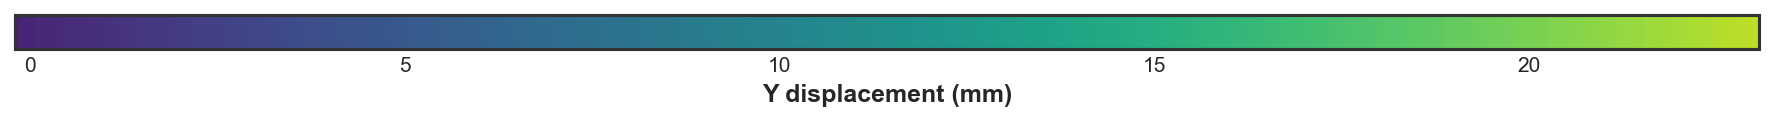

In [99]:
fig_cbar, ax_cbar = plt.subplots(figsize=(15, 0.3), dpi=150)  # Adjust size to be long and narrow
cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=custom_cmap, norm=norm, orientation='horizontal')

# Label the colorbar
cbar.set_label('Y displacement (mm)', fontsize=12, fontweight='bold')

# Save and show colorbar separately
plt.savefig('colorbar_figure.pdf', bbox_inches='tight', dpi=300)
plt.show()


<Axes: xlabel='minutes', ylabel='X displacement smoothed (mm)'>

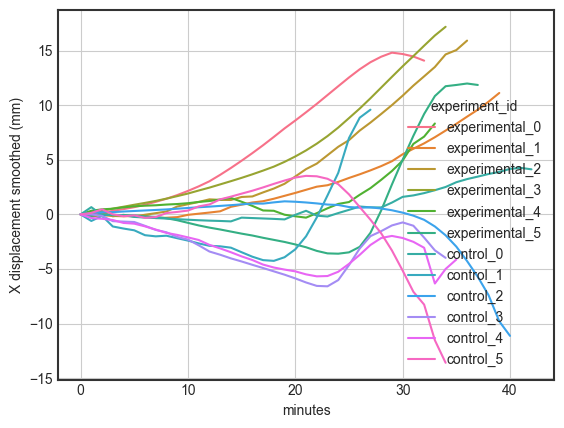

In [78]:
# List of file paths for all datasets
file_paths = {
    "experimental_0": ("tracked_trajectories/bimorph_idx0_100x_tracked.csv", (0, 33)),
    "experimental_1": ("tracked_trajectories/bimorph_idx1_100x_tracked.csv", (0, None)),
    "experimental_2": ("tracked_trajectories/bimorph_idx2_100x_tracked.csv", (0, None)),
    "experimental_3": ("tracked_trajectories/bimorph_idx3_100x_tracked.csv", (0, None)),
    "experimental_4": ("tracked_trajectories/bimorph_idx4_100x_tracked.csv", (0, None)),
    "experimental_5": ("tracked_trajectories/bimorph_idx5_100x_tracked.csv", (0, None)),
    'control_0': ('tracked_trajectories/control_idx0_100x_tracked.csv', (0, 43)),
    'control_1': ('tracked_trajectories/control_idx1_100x_tracked.csv', (0, None)),
    'control_2': ('tracked_trajectories/control_idx2_100x_tracked.csv',(0, None)),
    'control_3': ('tracked_trajectories/control_idx3_100x_tracked.csv', (0, 35)), # window=3
    'control_4': ('tracked_trajectories/control_idx4_100x_tracked.csv', (0, None)),
    'control_5': ('tracked_trajectories/control_idx5_100x_tracked.csv',(0, 35)),
}

# Load and normalize each DataFrame, adding an experiment_id column
dfs = []
for name, (file, frames) in file_paths.items():
    df = normalize_df(pd.read_csv(file))  # Apply your normalize function
    df["experiment_id"] = name  # Label each dataset
    df = df[frames[0]:frames[1]]  
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Plot with seaborn (different lines per experiment)
sns.lineplot(
    data=combined_df, x="minutes", y="X displacement smoothed (mm)", hue="experiment_id"
)